## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from scipy.stats import f
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.signal import find_peaks
import matplotlib.patches as patches

# Accessing the cleaned data set
CLEANED_DATA_PATH = f'/Users/merlinalfredsson/Notebooks/GNSS_Displacement/Github/Project_Earthquake_Detection/Storage/New_Storage/Data/dfs.pkl'
# Which directions to include for the chow test (Options are N, E and U)
DIRECTIONS = ['N','E']
# Path to store the mean predictions plots
MEAN_PLOTS_PATH = f'/Users/merlinalfredsson/Notebooks/GNSS_Displacement/Github/Project_Earthquake_Detection/Storage/Plots/'

## Functions

### Chow test

In [2]:
def chow_test(df, alpha=0.01, threshold=1, direction='N'):
    """
    Perform the Chow test for structural breaks in a time series.
    Add offsets detected using statistical logic directly as a new column.

    Parameters:
        df (pd.DataFrame): DataFrame with the time series data.
        alpha (float): Significance level for the Chow test.
        threshold (float): Threshold to classify a break as significant.
        direction (str): Direction to test (e.g., 'N', 'E', 'U').

    Returns:
        pd.DataFrame: DataFrame with 'score', 'break', and 'predicted_offsets'.
    """
    chow_df = df.copy()  # Create a copy of the input DataFrame to avoid modifying original df
    chow_df['score'] = np.nan  # Initialize scores to NaN
    chow_df['predicted_offsets'] = 0  # Initialize predicted offsets to 0 (ensure column is created)

    n = len(df)
    window_N = 30
    k = 2  # Number of parameters estimated in regression

    predicted_offsets = [0] * (window_N // 2)  # Initialize with zeros for the first half (edges)
    scores =  [0] * (window_N // 2) 

    for i in range(n - window_N + 1):
        # Define windows
        full_window = df.iloc[i:i + window_N]
        left = full_window.iloc[:window_N // 2]
        right = full_window.iloc[window_N // 2:]

        # Full window statistics
        y_window = full_window[direction].values
        coef_window = np.polyfit(np.arange(window_N), y_window, 1)
        pred_window = np.polyval(coef_window, np.arange(window_N))
        Sc = np.sum((y_window - pred_window) ** 2)

        # Left window
        y_left = left[direction].values
        coef_left = np.polyfit(np.arange(len(left)), y_left, 1)
        pred_left = np.polyval(coef_left, np.arange(len(left)))
        S1 = np.sum((y_left - pred_left) ** 2)
        N1 = len(left)

        # Right window
        y_right = right[direction].values
        coef_right = np.polyfit(np.arange(len(right)), y_right, 1)
        pred_right = np.polyval(coef_right, np.arange(len(right)))
        S2 = np.sum((y_right - pred_right) ** 2)
        N2 = len(right)

        # Calculate CTS score
        cts = ((Sc - (S1 + S2)) / k) / ((S1 + S2) / (N1 + N2 - 2 * k))
        dfd = N1 + N2 - 2 * k
        c_value = f.ppf(q=1 - alpha, dfn=k, dfd=dfd)
        score = cts / c_value

        # Mark break if score exceeds threshold
        chow_df.at[full_window.index[window_N // 2], 'score'] = cts
        if abs(score) > threshold:
            predicted_offsets.append(1)  # Mark this index as a predicted offset
            scores.append(score)  
        else:
            predicted_offsets.append(0)  # Otherwise mark as no offset
            scores.append(0)


    # Fill the predicted_offsets array with 0 for the last edge (to match DataFrame length)
    predicted_offsets.extend([0] * (window_N // 2))  # Pad the edges of the array
    scores.extend([0] * (window_N // 2))  # Pad the edges of the array

    # Ensure predicted_offsets is the same length as the original DataFrame
    chow_df['predicted_offsets'] = predicted_offsets[:len(chow_df)] 
    chow_df['score'] = scores[:len(chow_df)]  

    return chow_df



def apply_chow_test(stations_list, alpha=0.01, threshold=10):
    """
    Apply Chow Test and append predicted offsets as columns to the DataFrames.
    
    Parameters:
        stations_list (list): List of DataFrames representing different stations.
        alpha (float): Significance level for the Chow test.
        threshold (float): Offset detection threshold.

    Returns:
        list: Updated DataFrame with additional `predicted_offsets`.
    """
    updated_dfs = []
    # List of stations the chow test is applied on, extracted from the test set of the ML-algorithms
    test_list = [42,142,264,24,122,137,154,318,304,164,68,207,1,37,214,296,107,200,270,249,62,303,45,136,209,294,130,229,289,172,112,204,167,254,217,246,90,323,205,212,253,25,288,185,109,6,118,159,202,169]

    for idx, station_df in enumerate(stations_list):
            
        if idx in test_list:
            station_df['predicted_offsets'] = 0
            station_df['score'] = 0
            # Apply peak offset detection and Chow logic here
            for direction in DIRECTIONS:
                # Perform simple predicted offset detection here directly.
                predicted_offsets_series = chow_test(station_df[[direction]], alpha, threshold, direction)
                # Add offsets column directly
                station_df['predicted_offsets'] += predicted_offsets_series['predicted_offsets']
                station_df['score'] += predicted_offsets_series['score']

            updated_dfs.append(station_df)

    return updated_dfs

### Evaluation

In [3]:
def evaluate_offsets(chow_dfs, tolerance_window=10):
    """
    Evaluate predicted offsets against true offsets within a given tolerance window.

    Parameters:
        chow_dfs (list): List of DataFrames with 'true_offsets' and 'predicted_offsets' columns.
        tolerance_window (int): The tolerance window (in days) to consider for a true positive match.

    Returns:
        dict: A dictionary with precision, recall, and F1 score for each DataFrame (station).
        dict: A dictionary with total TP, FP, FN, TN across all stations.
    """
    evaluation_results = {}
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_tn = 0

    for idx, df in enumerate(chow_dfs):
        # Ensure index is datetime
        df.index = pd.to_datetime(df.index)

        # Predicted and true offsets
        true_offsets = df['true_offsets'].values
        predicted_offsets = df['predicted_offsets'].values

        # Find indices of true offsets (actual offset days)
        true_offset_indices = np.where(true_offsets == 1)[0]
        
        # Initialize lists to hold matched true positives (TP)
        tp_matches = []

        # Compare each predicted offset with the true offsets within the tolerance window
        for i in range(len(df)):
            if predicted_offsets[i] == 1:
                # Check if there's any true offset within the tolerance window
                for true_offset_index in true_offset_indices:
                    if abs(i - true_offset_index) <= tolerance_window:
                        tp_matches.append(i)
                        break  # Stop after the first match

        # Calculate Precision, Recall, and F1 Score
        tp = len(tp_matches)
        fp = np.sum(predicted_offsets) - tp  # False positives: predicted offsets that didn't match true ones
        fn = len(true_offset_indices) - tp  # False negatives: true offsets that didn't have a match

        # Update totals
        total_tp += tp
        total_fp += fp
        total_fn += fn
        total_tn += len(df) - (tp + fp + fn)  # True negatives: the rest are true negatives

        # Precision, Recall, F1 calculation
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store the evaluation results for the station
        evaluation_results[idx] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    # Calculate total Precision, Recall, and F1 across all stations
    if (total_tp + total_fp) > 0:
        total_precision = total_tp / (total_tp + total_fp)
    else:
        total_precision = 0
    
    if (total_tp + total_fn) > 0:
        total_recall = total_tp / (total_tp + total_fn)
    else:
        total_recall = 0
    
    if (total_precision + total_recall) > 0:
        total_f1 = 2 * (total_precision * total_recall) / (total_precision + total_recall)
    else:
        total_f1 = 0

    # Return evaluation results for individual stations and total TP, FP, FN, TN
    return evaluation_results, {
        'total_tp': total_tp,
        'total_fp': total_fp,
        'total_fn': total_fn,
        'total_tn': total_tn,
        'total_precision': total_precision,
        'total_recall': total_recall,
        'total_f1': total_f1
    }


### Helping functions

In [4]:
def parse_offsets(offsets):
    """
    Parse offsets from n, e, and u directions and return a dictionary mapping dates to their max offset value.
    
    Parameters:
        offsets (dict): Dictionary with 'n', 'e', and 'u' offset data.

    Returns:
        dict: Dictionary mapping dates to their respective maximum offset values.
    """
    offset_dict = {}

    # Parse 'n', 'e', 'u' offsets for their dates
    for direction in ['n', 'e', 'u']:
        if direction in offsets and 'offsets' in offsets[direction]:
            for offset in offsets[direction]['offsets']:
                if offset.get('coseismic', False):  # Only consider coseismic offsets
                    date = offset.get('date')
                    if date:
                        # Parse string date into a datetime.date object
                        offset_date_parsed = datetime.strptime(date, '%Y-%m-%d').date()
                        # Update the dictionary with the maximum offset value
                        offset_value = abs(offset['value'])
                        if offset_date_parsed in offset_dict:
                            offset_dict[offset_date_parsed] = max(offset_dict[offset_date_parsed], offset_value)
                        else:
                            offset_dict[offset_date_parsed] = offset_value

    return offset_dict


def create_chow_dfs(cleaned_dfs):
    """
    Create a list of DataFrames for Chow test preparation with cleaned offsets, a binary column
    based on presence of offsets, and a new column 'offset_value'.
    
    Parameters:
        cleaned_dfs (list): List of DataFrames with station data and their respective offsets.

    Returns:
        list: List of DataFrames with N, E, U columns, 'true_offsets' binary column, and 'offset_value'.
    """
    chow_dfs = []

    for station_df in cleaned_dfs:
        # Extract N, E, U columns
        chow_df = station_df[['N', 'E', 'U']].copy()

        # Parse offsets
        offsets = station_df.attrs.get('offsets', {})
        offset_dict = parse_offsets(offsets)

        # Map binary column (1 if offset on that date, 0 otherwise)
        chow_df['true_offsets'] = chow_df.index.date  # Ensure index is date-only for comparison
        chow_df['true_offsets'] = chow_df['true_offsets'].apply(lambda date: 1 if date in offset_dict else 0)

        # Map offset_value (set value if offset exists, otherwise 0)
        chow_df['offset_value'] = chow_df.index.date
        chow_df['offset_value'] = chow_df['offset_value'].apply(lambda date: offset_dict[date] if date in offset_dict else 0)

        # Append to list
        chow_dfs.append(chow_df)

    return chow_dfs

def find_peaks_in_offsets(chow_dfs, window_size=60):
    """
    Detect peaks in the offset values over a sliding window and update the `true_offsets`.
    
    Parameters:
        chow_dfs (list): List of DataFrames with 'offset_value' and 'true_offsets' columns.
        window_size (int): Size of the sliding window to consider for peak detection.

    Returns:
        list: Updated DataFrames with `true_offsets` set only at peak values.
    """
    updated_chow_dfs = []

    for df in chow_dfs:
        # Ensure index is datetime
        df.index = pd.to_datetime(df.index)

        # Detect local maxima within a sliding window
        offset_series = df['offset_value']
        rolling_max = offset_series.rolling(window=window_size, center=True).max()

        # Update `true_offsets`: Set only at peaks and if offset_value is not 0
        df['true_offsets'] = 0  # Start with all zeros
        df['true_offsets'] = df.apply(
            lambda row: 1 if row['offset_value'] != 0 and row['offset_value'] == rolling_max.loc[row.name] else 0, axis=1
        )

        # Append to the new list
        updated_chow_dfs.append(df)

    return updated_chow_dfs



def find_peaks_in_preds(chow_dfs, window_size=60):
    """
    Detect peaks in the pred score values over a sliding window and update the `score`.
    
    Parameters:
        chow_dfs (list): List of DataFrames with 'score' and 'predicted_offsets' columns.
        window_size (int): Size of the sliding window to consider for peak detection.

    Returns:
        list: Updated DataFrames with `predicted_offsets` set only at peak values.
    """
    updated_chow_dfs = []

    for df in chow_dfs:
        # Ensure index is datetime
        df.index = pd.to_datetime(df.index)

        # Detect local maxima within a sliding window
        offset_series = df['score']
        rolling_max = offset_series.rolling(window=window_size, center=True).max()

        # Update `true_offsets`: Set only at peaks
        df['predicted_offsets'] = 0
        df['predicted_offsets'] = df.apply(
            lambda row: 1 if row['score'] != 0 and row['score'] == rolling_max.loc[row.name] else 0, axis=1
        )

        # Append to the new list
        updated_chow_dfs.append(df)

    return updated_chow_dfs

### Plotting

In [5]:
def plot_offsets(df, direction_columns=['N', 'E', 'U']):
    """
    Plot the time series for N, E, U directions with vertical lines for true_offsets and predicted_offsets.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series and offset columns.
        direction_columns (list): List of direction columns to plot (default ['N', 'E', 'U']).

    Returns:
        None
    """
    # Create a figure with subplots for N, E, U directions
    fig, axes = plt.subplots(len(direction_columns), 1, figsize=(12, 6), sharex=True)
    if len(direction_columns) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    # Loop through each direction column (N, E, U)
    for i, direction in enumerate(direction_columns):
        ax = axes[i]
        
        # Plot the movement for the current direction
        ax.plot(df.index, df[direction], label=f'{direction} Movement', color='blue', lw=1)
        
        # Plot vertical lines where true_offsets == 1
        true_offsets = df[df['true_offsets'] == 1]
        ax.vlines(true_offsets.index, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', label='True Offsets', linestyle='-')
        
        # Plot vertical lines where predicted_offsets == 1
        predicted_offsets = df[df['predicted_offsets'] == 1]
        ax.vlines(predicted_offsets.index, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='green', label='Predicted Offsets', linestyle=':')

        # Set labels, title, and legend
        ax.set_ylabel('Movement')
        ax.set_title(f'{direction} Movement with Offsets')
        ax.grid(True)
        
        # Avoid duplicate labels in the legend
        handles, labels = ax.get_legend_handles_labels()
        unique_handles = {}
        for handle, label in zip(handles, labels):
            unique_handles[label] = handle
        ax.legend(unique_handles.values(), unique_handles.keys())

    # Set the x-axis label and show the plot
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

def plot_mean_preds_statistics(values, chunk_size=21):
    """
    This function generates a bar chart to visualize the prediction accuracy statistics. The bars represent 
    different categories of prediction performance, including exact matches, predictions within a tolerance window, 
    undetected earthquakes, and false positives. The chart is saved as a PNG file using the specified name and PLOTS_PATH variable.

    Parameters:
    values (tuple): A tuple containing the percentages of each category. The order should match 
                    the labels: ['Exact Matches', 'Predicted within chunk_size Days', 'Undetected', 'False Positives'].
    name (str): Name used for saving the plot.
    chunk_size (int): The window (in days) within which a predicted label is considered acceptable (default: CHUNK_SIZE).

    Returns:
    None
    """
    # Define standard font sizes and other plotting parameters for consistency
    legend_fontsize = 16
    label_fontsize = 20
    title_fontsize = 22
    tick_fontsize = 14
    dpi_setting = 300
    plot_size = (12, 8)
    subplot_size = (14, 12)
    
    labels = ['Exact Matches', f'Predicted within 21 Days', 'Undetected', 'False Positives']
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
    
    plt.figure(figsize=plot_size)
    bars = plt.bar(labels, values, color=colors, edgecolor='black', linewidth=1.5)
    plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
    
    plt.ylabel('Percentage', fontsize=label_fontsize, labelpad=15)
    plt.title("Prediction Accuracy Breakdown", fontsize=title_fontsize, pad=20)
    plt.ylim(0, 100)
    
    for i, v in enumerate(values):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=legend_fontsize, color='black')
    
    plt.xticks(fontsize=tick_fontsize, rotation=45, ha='center')
    plt.yticks(fontsize=tick_fontsize)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'{MEAN_PLOTS_PATH}Chow_neu.png', dpi=dpi_setting, bbox_inches='tight')
    plt.show()
    plt.close()

## Calling the functions

### Load and prepare the cleaned data

In [6]:
loaded_df_dict = pd.read_pickle(CLEANED_DATA_PATH)
for key, df in loaded_df_dict.items():
    df.name = key
print("loaded data!")
cleaned_dfs = [df for df in loaded_df_dict.values()]

loaded data!


In [7]:
chow_dfs = create_chow_dfs(cleaned_dfs)
chow_dfs = find_peaks_in_offsets(chow_dfs)

In [8]:
# Apply Chow test logic to all stations
stations_with_offsets = apply_chow_test(chow_dfs, alpha=0.001, threshold=3)
processed_chow_dfs = find_peaks_in_preds(stations_with_offsets)

In [9]:
# Plot a section out of the DF as an example
processed_chow_dfs[45][255:260]

,N,E,U,true_offsets,offset_value,predicted_offsets,score
2018-11-28,-0.2191,-0.1180,0.0806,0,0.00,0,0.000000
2018-11-29,-0.2177,-0.1179,0.0772,0,0.00,0,0.000000
2018-11-30,-0.2148,-0.1148,0.0758,0,0.00,1,10.535808
2018-12-01,-0.2078,-0.1124,0.0712,1,12.73,0,6.175020
2018-12-02,-0.2061,-0.1134,0.0673,0,0.00,0,0.000000


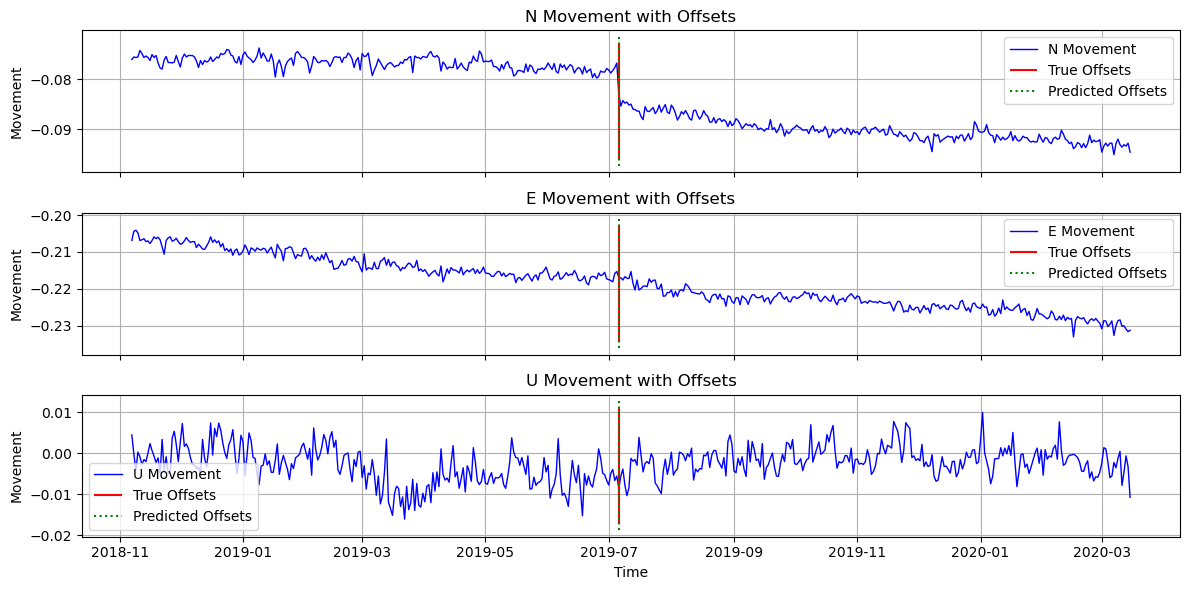

In [10]:
# Plot N, E, U with vertical lines for true_offsets and predicted_offsets for an example station
plot_offsets(processed_chow_dfs[10])

### Choose the treshold for the chow test

In [11]:
# Define a list of DataFrames `chow_dfs` where each contains 'true_offsets' and 'predicted_offsets' columns
# Call the evaluation function with a tolerance window of 21 days
results, total_results_21 = evaluate_offsets(processed_chow_dfs, tolerance_window=21)
# Call the evaluation function with a tolerance window of 1 day
results, total_results_1 = evaluate_offsets(processed_chow_dfs, tolerance_window=1)

# Print total TP, FP, FN, TN across all stations
print("\nTotal Evaluation across all stations:")
print(f"Total TP: {total_results_1['total_tp']}")
print(f"Total FP: {total_results_1['total_fp']}")
print(f"Total FN: {total_results_1['total_fn']}")
print(f"Total TN: {total_results_1['total_tn']}")
print(f"Total Precision: {total_results_21['total_precision']:.2f}")
print(f"Total Recall: {total_results_21['total_recall']:.2f}")
print(f"Total F1 Score: {total_results_21['total_f1']:.2f}")




Total Evaluation across all stations:
Total TP: 38
Total FP: 46
Total FN: 19
Total TN: 32583
Total Precision: 0.48
Total Recall: 0.70
Total F1 Score: 0.57


### Chose the treshold for the number of days

First the testing indixes were ignored (not in testing_list) for parameter searching. Then the parameters were applied on testing list.
Higher number of Offsets as coordinates needed to be handeled sepereately

[66.66666666666666, 3.508771929824561, 29.82456140350877, 80.7017543859649]


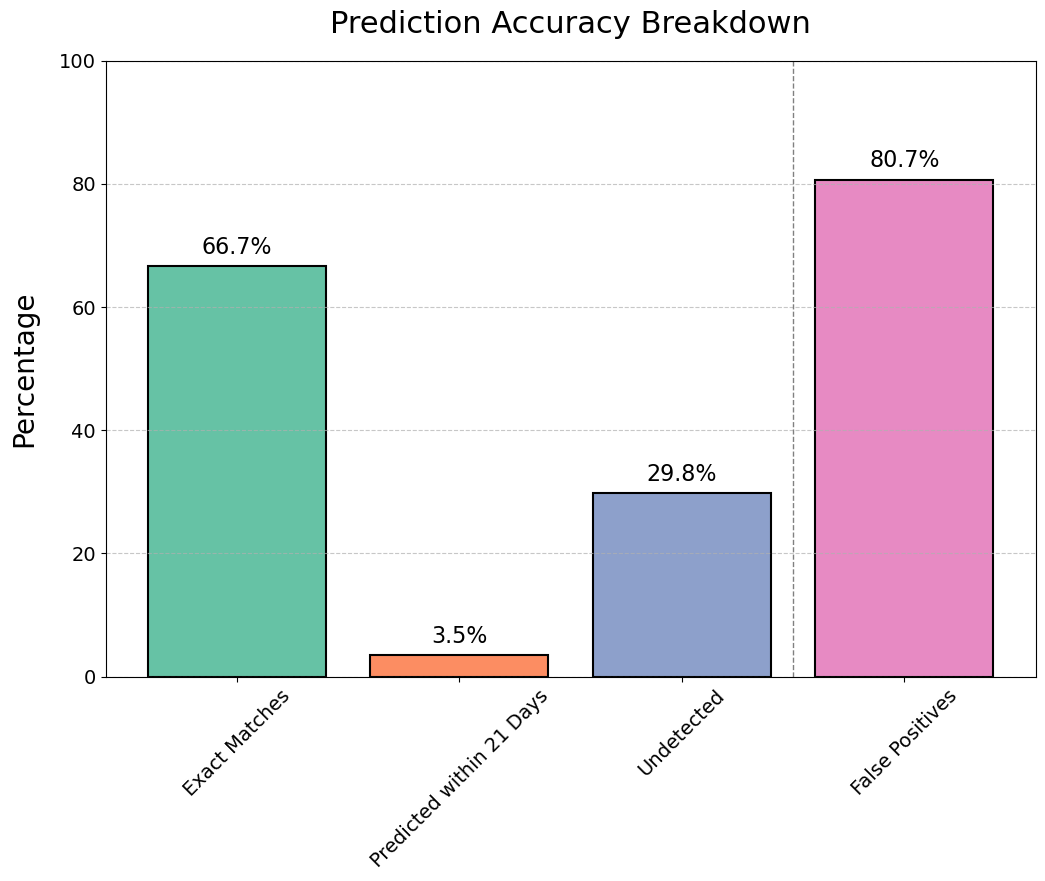

In [12]:
total = total_results_1['total_tp'] + total_results_1['total_fn']
exact = 100 / total * total_results_1['total_tp']
window = 100 / total * (total_results_21['total_tp']-total_results_1['total_tp'])
undetected =  100 / total * total_results_21['total_fn']
false_positive = 100 / total * total_results_1['total_fp']
values = [exact, window, undetected, false_positive]

values = [exact, window, undetected, false_positive]
print(values)
plot_mean_preds_statistics(values, "mean_adjusted_bars_e")